In [3]:
%matplotlib notebook
import sys 
sys.path.append(r"D:\Code\Qcodes")

import matplotlib.pyplot as plt
import time
import math
import matplotlib as mpl
import glob
import os
import scipy as sci
from scipy import signal

mpl.rcParams['figure.dpi'] = 60 #dpi 100 before

import numpy as np
import qcodes as qc

from qcodes.instrument import base, parameter
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
from qcodes.instrument_drivers.tektronix.Keithley_2000 import Keithley_2000
from qcodes.instrument_drivers.stanford_research.SR830 import SR830
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430, AMI430_3D
from qcodes.sweep import sweep, getter, setter, \
    SweepMeasurement, nest, SweepWhile, time_trace, \
    parallel_sweep, szip
from qcodes import ParamSpec, new_data_set, new_experiment, Station


from qcodes.dataset.plotting import plot_by_id, get_data_by_id
from qcodes.dataset.live_monitor import Plot1DSubscriber
#from plottr.qcodes_dataset import QcodesDatasetSubscriber as LivePlotSubscriber

In [4]:
import analysis as a


In [5]:
qc.__version__

'0.1.11'

# INSTRUMENTS

In [6]:
ivvi = IVVI(
    name="ivvi", address="ASRL6", reset=False, numdacs=16, dac_step=10, dac_delay=0.01, polarity=['BIP','BIP','BIP','BIP']
)

keithley_1 = Keithley_2000(name="keithley_1", address='GPIB0::15')
keithley_2 = Keithley_2000(name="keithley_2", address='GPIB0::16')

lockin_1 = SR830(name="lockin_1", address='GPIB::8')
lockin_2 = SR830(name="lockin_2", address='GPIB::12')

ramp_limit_multiplier = 0.3   #magnet rate old 0.1

ami_x =  AMI430('AMI430_X', '169.254.204.108', port=7180)
ami_x.coil_constant(0.0386)
ami_x.current_rating(51.81)
ami_x.current_ramp_limit(0.027*ramp_limit_multiplier)

ami_y =  AMI430('AMI430_Y', '169.254.201.52', port=7180)
ami_y.coil_constant(0.0242)
ami_y.current_rating(82.64)
ami_y.current_ramp_limit(0.020*ramp_limit_multiplier)

ami_z =  AMI430('AMI430_Z', '169.254.56.162', port=7180)
ami_z.coil_constant(0.0760)
ami_z.current_rating(78.95)
ami_z.current_ramp_limit(0.120*ramp_limit_multiplier)


AMI = AMI430_3D('AMI430_3D', ami_x, ami_y, ami_z, field_limit=2)

Initialized IVVI-rack in 0.99s
Connected to: KEITHLEY INSTRUMENTS INC. 2000 (serial:4107733, firmware:B01  /A02) in 0.11s
Connected to: KEITHLEY INSTRUMENTS INC. 2000 (serial:4117111, firmware:B01  /A02) in 0.06s


D:\Code\Qcodes\qcodes\instrument\parameter.py:211: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


Connected to: Stanford_Research_Systems SR830 (serial:s/n48001, firmware:ver1.07) in 0.06s
Connected to: Stanford_Research_Systems SR830 (serial:s/n54434, firmware:ver1.07) in 0.04s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.74s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.72s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.85s


In [7]:
inst = [AMI, ivvi, keithley_1, keithley_2, lockin_1, lockin_2]
station = qc.Station(*inst)

Snapshot: Could not update parameter:trigger_count
Snapshot: Could not update parameter:trigger_count


In [6]:
#empting buffer in case of switch in the lockin output. This empties the buffer.

try:
    while True:
        lockin_1.visa_handle.read()
except:
    pass

In [7]:
AMI.close_all()

In [13]:
ami_y.field(0)

# Magnet checks


Check ramp limits

In [43]:
print(ami_x.field_ramp_limit())
print(ami_y.field_ramp_limit())
print(ami_z.field_ramp_limit())

0.00031266
0.0001452
0.0027359999999999997


Read magnet ramp rate

In [44]:
print('Rate X ax:', ami_x.ramp_rate())
print('Rate Y ax:',ami_y.ramp_rate())
print('Rate Z ax:',ami_z.ramp_rate())

Rate X ax: 2e-05
Rate Y ax: 0.00015
Rate Z ax: 0.0004


In [8]:
ami_z.ramp_rate(0.001)

In [18]:
ami_z.field(0)

In [19]:
ami_y.field(0)

In [20]:
ami_x.field(0)

# Example functions

Example 2D scan

Example 2D
#top is slow axes
```python
sweep_object = sweep(ivvi.dac2, np.linspace(V_start, V_end, n_steps))(
    sweep(ivvi.dac1, np.linspace(V_start, V_end, n_steps))(
        measure_DC
    )
)

# Or....
sweep_object = nest(
    sweep(ivvi.dac3, np.linspace(V_start, V_end, n_steps)), 
    sweep(ivvi.dac2, np.linspace(V_start, V_end, n_steps)), 
    measure_DC
)

```

Example of scan with parallel parameters

ivvi.dac1(-6)


ivvi.dac3(-350) #RG
B_start = 0.690
B_end = 0.790
n_steps = 200

sweep_object = nest(   
    parallel_sweep(
        (ivvi.dac6, np.linspace(0, 1000, 150)),
        (ivvi.dac7, np.linspace(300, 1000, 150)),
        (ivvi.dac8, np.linspace(100, 1000, 150))
    ), 
    measure_DC
)

live_plot_axes = {"ivvi_dac6": 1, "conductance": 6}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]
)




In [ ]:
s1 = sweep(p1, [0, 1, 2])
s2 = sweep(p2, [5, 6, 7])

s3 = zip(s1, s2)

for i in s3: 
    pass

ParallelSweep((p1, [0, 1, 2]), (p2, [5, 6, 7]))

# INIT, MEASURE & END

In [9]:
def init_DC():
    
    keithley_1.auto_range_enabled(True)
    keithley_1.nplc(1)
    
    keithley_2.auto_range_enabled(True)
    keithley_2.nplc(1)
    
    lockin_1.frequency(77.89)
    #lockin_1.sensitivity(0.005)
    #lockin_1.time_constant(0.3)
    #lockin_1.amplitude(1)
    
    lockin_2.frequency(89)
    lockin_2.sensitivity(0.005)
    lockin_2.time_constant(0.3)
    lockin_2.amplitude(1)

def set_params(): 
    lockin_1.amplitude(lockin1_amplitude)
    lockin_2.amplitude(lockin2_amplitude)
    lockin_1.sensitivity(0.0005) # does not work, why?
    lockin_2.sensitivity(0.0005)
    lockin_1.time_constant(0.1)
    lockin_2.time_constant(0.1)

    
@getter([
    ("keithley_1", "V"),
    ("keithley_2", "V"),
    ("lockin_1_X", "V"), 
    ("lockin_1_phase", "deg"), 
    ("lockin_1_processed", "S"),
    ("conductance", "G_0"), 
    
])
def measure_DC():
    
    k_1 = keithley_1.amplitude()
    k_2 = keithley_2.amplitude()
    lockin1_x = lockin_1.X()
    lockin1_p = lockin_1.P()    
    lockin1_processed = (lockin1_x/Imeas)/(amplitude_1/np.sqrt(2.0)-lockin1_x/Imeas*Rs)
    conductance = 12906.4037*lockin1_processed
    
    return  k_1, k_2, lockin1_x, lockin1_p, lockin1_processed, conductance, PG, RG
    
def end_DC():
    #ivvi.set_dacs_zero()
    print('Measurement completed')
    pass

def find_all_files(file_name_pattern, data_folder): 
    files = os.listdir(data_folder)
    files = [f.strip(".txt") for f in files if file_name_pattern in f]
    
    if len(files) == 0: 
        return 0
    
    return max([int(f.split("_")[1]) for f in files])

# Functions for field sweeps

In [10]:
#misalignment



phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001


def not_at_setpoint(set_point, tolerance):
    
    @getter([
        ("field_x", "T"), 
        ("field_y", "T"),
        ("field_z", "T")
    ])
    def inner(): 
        fx = ami_x.field()
        fy = ami_y.field()
        fz = ami_z.field()
        
        if all([abs(fi - sp) < tolerance for fi, sp in zip([fx, fy, fz], set_point)]):
            return None, None, None
        
        return fx, fy, fz
    
    return inner 

def goto_setpoint(start_x, start_y, start_z, end_x, end_y, end_z):
    
    #Setting Starting points (waiting for end sweep, with block = True)
    print("setting x start")
    ami_x.set_field(start_x)
    print("setting y start")
    ami_y.set_field(start_y)
    print("setting z start")
    ami_z.set_field(start_z)
    
    #Going to end points
    print("setting x end")
    ami_x.set_field(end_x, block=False)
    print("setting y end")
    ami_y.set_field(end_y, block=False)
    print("setting z end")
    ami_z.set_field(end_z, block=False)

#  DO EXPERIMENT

In [34]:
import os 

class DoExperiment: # replace do_experiment with DoExperiment
    _counter = {}
    
    def __init__(
        self, name, before_functions, sweep_object, 
        after_functions, out_file=None, live_plot_axes=None
    ): 
        """
        name (string): name of the experiment in the database
        
        before_functions (list): List of tuples: (callable, args). 
            The callables are executed before doing the experiment
        
        sweep_object: Defines the experiement loop
        
        after_functions (list): List of tuples: (callable, args). 
            The callables are executed after doing the experiment
        
        out_file (string): The path to a text based output file 
        
        live_plot_axes (list): A list of dictionaries. Each dictionary 
            specifies a live plot. The keys are axis labels. And the 
            values are columns to be plotted.
        """

        if name not in DoExperiment._counter: 
            DoExperiment._counter[name] = 1
        else:
            DoExperiment._counter[name] += 1
        
        sample_name = name + "_{}".format(DoExperiment._counter[name]) 

        exp = new_experiment(name, sample_name=sample_name)
        meas = SweepMeasurement(station=station) 
        
        if live_plot_axes is not None: 
            for live_plot_axis in live_plot_axes:
                meas.add_subscriber(Plot1DSubscriber(live_plot_axis), {})

        #init
        for func, args in before_functions: 
            meas.add_before_run(func, args)

        #meas
        meas.register_sweep(sweep_object)

        #end
        for func, args in after_functions: 
            meas.add_after_run(func, args)

        fh = None
        header = None
        os.chdir(r"D:\pycharmprojects\insects")  #  folder where the data lies.
        data_folder = "U21"

        if out_file is not None:

            if "_{counter}" in out_file:               
                out_file, ext = os.path.splitext(out_file)     
                counter = find_all_files(out_file.strip("_{counter}"), data_folder)
                out_file = out_file.format(counter=counter+1) + f"{ext}"

            fh = open(os.path.join(data_folder, out_file) , "w")

        #perform exp    
        with meas.run() as datasaver: 
            
            # add other subscriber for the plottr (see the xample notebook)
            
            for data in sweep_object: 
                datasaver.add_result(*data.items())

                if fh is not None: 

                    if header == None: 
                        header = data.keys()
                        line = "\t".join([str(i) for i in header])
                        fh.write(line + "\n")

                    line = "\t".join([str(data[k]) for k in header])
                    fh.write(line + "\n")
                    fh.flush()

            dataid = datasaver.run_id  # convenient to have for plotting

        if fh is not None:
            fh.close()

        print("data id = ", dataid)


def export_as_dict(dataid): 
    
    alldata = get_data_by_id(dataid)
    new_data = {}

    for data in alldata: 
        for d in data:
            name = "{} [{}]".format(d["name"], d["unit"])

            if name not in new_data: 
                new_data[name] = np.ravel(d["data"])
    
    return new_data

# MEASUREMENT

## Dac settings

Ivvi properties

In [12]:
Rs=23e3 #depends on the selected leads (18kOhm if both pads have 5kOhm)
Vrange=1e-3
Imeas=1e6
amplitude_1 = 15e-6  #Volt
lockin1_amplitude = amplitude_1*1e2/(Vrange*np.sqrt(2))
lockin2_amplitude = amplitude_1*1e2/(Vrange*np.sqrt(2))
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0

ivvi.dac1(0)
ivvi.dac2(0)
ivvi.dac3(0)
ivvi.dac4(0)
ivvi.dac5(0)
ivvi.dac6(0)
ivvi.dac7(0)
ivvi.dac8(0)
ivvi.dac9(0)
ivvi.dac10(0)
ivvi.dac11(0)
ivvi.dac12(0)

Setting IVVI ramping rates

In [13]:
ivvi.dac1.step = 10  # 10 mv is the maximum step size of the dac

In [14]:
gate_inter_delay = 100e-3  
gate_post_delay = 100e-3

bias_inter_delay = 100e-3
bias_post_delay = 100e-3

ivvi.dac1.inter_delay = bias_inter_delay 
ivvi.dac1.post_delay = bias_post_delay

ivvi.dac2.inter_delay = gate_inter_delay 
ivvi.dac2.post_delay = gate_post_delay


ivvi.dac3.inter_delay = gate_inter_delay 
ivvi.dac3.post_delay = gate_post_delay


ivvi.dac4.inter_delay = gate_inter_delay 
ivvi.dac4.post_delay = gate_post_delay


ivvi.dac5.inter_delay = gate_inter_delay 
ivvi.dac5.post_delay = gate_post_delay


ivvi.dac6.inter_delay = gate_inter_delay 
ivvi.dac6.post_delay = gate_post_delay


ivvi.dac7.inter_delay = gate_inter_delay 
ivvi.dac7.post_delay = gate_post_delay


ivvi.dac8.inter_delay = gate_inter_delay 
ivvi.dac8.post_delay = gate_post_delay


ivvi.dac9.inter_delay = gate_inter_delay 
ivvi.dac9.post_delay = gate_post_delay


ivvi.dac10.inter_delay = gate_inter_delay 
ivvi.dac10.post_delay = gate_post_delay


ivvi.dac11.inter_delay = gate_inter_delay 
ivvi.dac11.post_delay = gate_post_delay

ivvi.dac12.inter_delay = gate_inter_delay 
ivvi.dac12.post_delay = gate_post_delay

ivvi.dac13.inter_delay = gate_inter_delay 
ivvi.dac13.post_delay = gate_post_delay

ivvi.dac14.inter_delay = gate_inter_delay 
ivvi.dac14.post_delay = gate_post_delay

ivvi.dac15.inter_delay = gate_inter_delay 
ivvi.dac15.post_delay = gate_post_delay

ivvi.dac16.inter_delay = gate_inter_delay 
ivvi.dac16.post_delay = gate_post_delay

In [15]:
print(ivvi.dac1()) #V_dc (1mV/V) -6
print(ivvi.dac2()) #BG (15V/V) 0
print(ivvi.dac3()) #RG (1V/V) -100 now: 400

print(ivvi.dac4())
print(ivvi.dac5())
print(ivvi.dac6())
print(ivvi.dac7())
print(ivvi.dac8())
print(ivvi.dac9())
print(ivvi.dac10())

print(ivvi.dac11()) #TG1 coarse (1V/V) -230 now: -560
print(ivvi.dac12()) #TG1 fine (10mV/V) 0 now: 200

print(ivvi.dac13()) #PG coarse (1V/V) 1600
print(ivvi.dac14()) #PG fine (10mV/V) 0

print(ivvi.dac15()) #TG2 coarse (1V/V) -300 now: -700
print(ivvi.dac16()) #TG2 fine (10mV/V) 2000 now: 2000

-6.012054627298312
-100.00762951094839
-1499.9923704890516
0.03051804379333589
0.03051804379333589
-550.0267032883194
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
-1835.9960326543069
0.03051804379333589
0.03051804379333589
2000.0
2000.0
0.03051804379333589


In [33]:
ivvi.dac1(1000)
ivvi.dac2(0)
ivvi.dac3(0)

In [32]:
ivvi.dac1(0)
ivvi.dac2(0)
ivvi.dac3(0)
ivvi.dac4(0)
ivvi.dac5(0)
ivvi.dac6(0)
ivvi.dac7(0)
ivvi.dac8(0)
ivvi.dac9(0)
ivvi.dac10(0)
ivvi.dac11(0)
ivvi.dac12(0)
ivvi.dac13(0)
ivvi.dac14(0)
ivvi.dac15(0)
ivvi.dac16(0)

## BG sweep

<IPython.core.display.Javascript object>


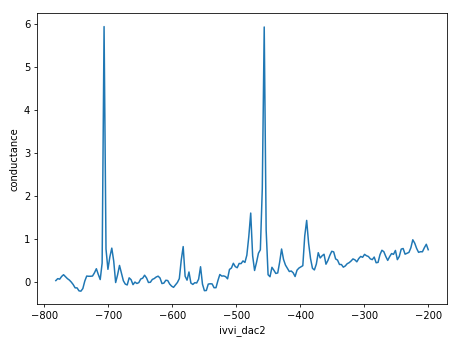

Starting experimental run with id: 7337
Measurement completed
data id =  7337


In [56]:
#dac 2 == BG
ivvi.dac1(1000)
V_start = -200
V_end = -800
n_steps = 200

sweep_object = sweep(ivvi.dac2, np.linspace(V_start, V_end, n_steps))(
    measure_DC
)

live_plot_axes = {"ivvi_dac2": 0, "conductance": 5}

dataid = DoExperiment(
    "device4", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )


## TG1 vs TG2

<IPython.core.display.Javascript object>


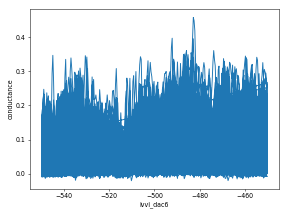

Starting experimental run with id: 7405
Measurement completed
data id =  7405


In [17]:
#Example 2D
#top is slow axes



ivvi.dac1(-6)
ivvi.dac2(-100)
ivvi.dac3(-1500)
ivvi.dac13(0)

live_plot_axes = {"ivvi_dac6": 1, "conductance": 6}
sweep_object = nest(
    sweep(ivvi.dac11, np.linspace(-1840, -1810, 200)), 
    sweep(ivvi.dac6, np.linspace( -550, -450, 300)), 
    measure_DC
)

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt" ,
    live_plot_axes=[live_plot_axes] 
    
)





## BG vs TG2

In [ ]:
#Example 2D
#top is slow axes


ivvi.dac1(1000)
ivvi.dac2(-500)
ivvi.dac3(-2000)


#ivvi.dac11(-190)
#ivvi.dac15(-220)
sweep_object = nest(
    sweep(ivvi.dac2, np.linspace(-500, 100, 50)), 
    sweep(ivvi.dac15, np.linspace(-2000, 500, 200)), 
    measure_DC
)

live_plot_axes = {"ivvi_dac15": 1, "conductance": 6}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes] 
    
)

## TG3 vs TG4

In [72]:
#Example 2D
#top is slow axes

'''
sweep_object = sweep(ivvi.dac2, np.linspace(V_start, V_end, n_steps))(
    sweep(ivvi.dac1, np.linspace(V_start, V_end, n_steps))(
        measure_DC
    )
)
'''

ivvi.dac1(24)
#ivvi.dac3(-190)
#ivvi.dac5(-220)
sweep_object = nest(
    sweep(ivvi.dac3, np.linspace(-975, -945, 300)), 
    sweep(ivvi.dac5, np.linspace(-1560, -1460, 500)), 
    measure_DC
)

dataid = DoExperiment(
    "device2", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device2_{counter}.txt" 
    
)




C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


Starting experimental run with id: 2751
Measurement completed
data id =  2751


## TG1 fine vs PG fine

In [26]:
ivvi.dac12()

939.986266880293

In [ ]:
ivvi.dac1(-6)

start_PG = 0
end_PG = 2000
steps_PG = 300
#alpha = 0.57

#conversion
start_TG1 = 0
#end_TG1 = start_TG1 + alpha *(end_PG-start_PG)
end_TG1 = 500
steps_TG1 = 20

live_plot_axes = {"ivvi_dac14": 1, "conductance": 6}

sweep_object = nest(
        sweep(ivvi.dac12, np.linspace(start_TG1, end_TG1 , steps_TG1 )), 
        sweep(ivvi.dac14, np.linspace(start_PG, end_PG, steps_PG)),
    measure_DC
) 

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes] 
    
)



## TG1 vs PG compensed vs Bperpendicular

In [18]:
By =ami_y.field()
Bx =ami_x.field()
Br = np.sqrt(By**2+Bx**2)
print(By)
print(Bx)
print(Br)

1.3812
-0.22865
1.3999979508913576


In [ ]:
ivvi.dac1(-6)

start_PG = -1800
end_PG = -1000
alpha = 0.57
start_TG1 = 0
end_TG1 = alpha *(end_PG-start_PG)
gate_steps = 150

#defining the radial component
start_Br = 1.400
end_Br =1.350
field_steps = 50

#calculating the cartesian values
start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)
start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)


print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)

live_plot_axes = {"ivvi_dac14": 3, "conductance": 8}

sweep_object = nest(
    parallel_sweep(
        (ami_y.field, np.linspace(start_y, end_y, field_steps)),
        (ami_x.field, np.linspace(start_x, end_x, field_steps)),    
    ), 
        parallel_sweep(
        (ivvi.dac12, np.linspace(start_TG1, end_TG1, gate_steps)),
        (ivvi.dac14, np.linspace(start_PG, end_PG, gate_steps)),    
    ), 
    
    
    measure_DC
)

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes] 
    
)



## Vbias vs PG fine

In [ ]:
#ivvi.dac1(-6)
#dac 13, 14 == PG coarse, fine
#vvi.dac11(-400)  # TG1000, 2000, 300 )), 
#vvi.dac15(-460)  # TG2
#ivvi.dac3(-300) #RG
#ivvi.dac1(-6)   #bias
#ivvi.dac13(0)  #PG coarse
#dac 13,14 == PG coarse, PG fine
#ivvi.dac13(0)  #PG coarse

RGs = np.linspace(-350, -380)

for RG in RGs:
    
    ivvi.dac3(RG) #RG
    

    live_plot_axes = {"ivvi_dac1": 1, "conductance": 6}

    sweep_object = nest(
            sweep(ivvi.dac14, np.linspace(2000, 2000, 60)),
            sweep(ivvi.dac1, np.linspace(-400, 400, 150)),
        measure_DC
    )

    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ())
        ], 
        sweep_object, 
        [
            (end_DC, ())
        ], out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes] 

    )

## TG2 vs PG fines

In [ ]:
ivvi.dac1(-6)
#dac 13, 14 == PG coarse, fine
#vvi.dac11(-400)  # TG1
#vvi.dac15(-460)  # TG2
#ivvi.dac3(-300) #RG
#ivvi.dac1(-6)   #bias
#ivvi.dac13(0)  #PG coarse
#dac 13,14 == PG coarse, PG fine
#ivvi.dac13(0)  #PG coarse


live_plot_axes = {"ivvi_dac14": 1, "conductance": 6}

sweep_object = nest(
        sweep(ivvi.dac16, np.linspace(100, 600 , 10 )), 
        sweep(ivvi.dac14, np.linspace(1000, 2000, 250)),
    measure_DC
)

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes] 
    
)

## Vbias vs PG

In [ ]:
sweep_object = nest(
    sweep(ivvi.dac14, np.linspace(2000, 600, 200)), 
    sweep(ivvi.dac1, np.linspace(-500, 500, 200)), 
    measure_DC
)

live_plot_axes = {"ivvi_dac1": 1, "conductance": 6}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    

    )



## RG vs PG fine

In [62]:
ivvi.dac3()

-347.9972533760588

In [ ]:
ivvi.dac1(-6)

start_PG = 400
end_PG = 1400
start_RG = -370
end_RG = -380


live_plot_axes = {"ivvi_dac14": 1, "conductance": 6}

sweep_object = nest(
        sweep(ivvi.dac3, np.linspace(start_RG, end_RG, 50)), 
        sweep(ivvi.dac14, np.linspace(start_PG, end_PG, 100)),
    measure_DC
) 

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes] 
    
)




## PG vs By


## PG vs B perpendicular

In [ ]:
ivvi.dac1(-6)
#ivvi.dac3(-355) #RG

#defining the radial component
start_Br = 1.290
end_Br = 1.590
n_steps = 450

#calculating the cartesian values
start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)
start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)


sweep_object = nest(    
    parallel_sweep(
        (ami_y.field, np.linspace(start_y, end_y, n_steps)),
        (ami_x.field, np.linspace(start_x, end_x, n_steps)),    
    ), 
    sweep(ivvi.dac14, np.linspace(0, 1500, 150)),     
    measure_DC
)

live_plot_axes = {"ivvi_dac14": 2, "conductance": 7}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]
)



In [ ]:
start_Br = 1.590
end_Br = 1.290
n_steps = 450

#calculating the cartesian values
start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)
start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)


sweep_object = nest(    
    parallel_sweep(
        (ami_y.field, np.linspace(start_y, end_y, n_steps)),
        (ami_x.field, np.linspace(start_x, end_x, n_steps)),    
    ), 
    sweep(ivvi.dac14, np.linspace(0, 1500, 150)),     
    measure_DC
)

live_plot_axes = {"ivvi_dac14": 2, "conductance": 7}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]
)


In [122]:
print(ivvi.dac1()) #V_dc (1mV/V) -6
print(ivvi.dac2()) #BG (15V/V) 0
print(ivvi.dac3()) #RG (1V/V) -100 now: 400

print(ivvi.dac4())
print(ivvi.dac5())
print(ivvi.dac6())
print(ivvi.dac7())
print(ivvi.dac8())
print(ivvi.dac9())
print(ivvi.dac10())

print(ivvi.dac11()) #TG1 coarse (1V/V) -230 now: -560
print(ivvi.dac12()) #TG1 fine (10mV/V) 0 now: 200

print(ivvi.dac13()) #PG coarse (1V/V) 1600
print(ivvi.dac14()) #PG fine (10mV/V) 0

print(ivvi.dac15()) #TG2 coarse (1V/V) -300 now: -700
print(ivvi.dac16()) #TG2 fine (10mV/V) 2000 now: 2000

0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589


## PG sweep

<IPython.core.display.Javascript object>


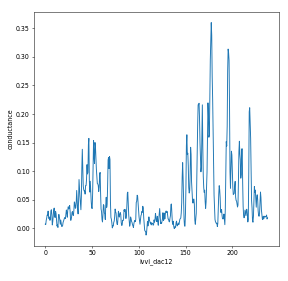

Starting experimental run with id: 7404
Measurement completed
data id =  7404


In [16]:

ivvi.dac1(-6)

#ivvi.dac2(-100)  #BG
ivvi.dac3(-1500) #RG

ivvi.dac11(-1836)  # TG1
#ivvi.dac12(0)  #TG1 fine
#ivvi.dac13(500)  # PG
#ivvi.dac14(0)  #PG fine
ivvi.dac6(-550)  # TG2


start = 0
end = 250
n_steps = 500

sweep_object = sweep(ivvi.dac12, np.linspace(start, end, n_steps))(
        measure_DC
    )
    
live_plot_axes = {"ivvi_dac12": 0, "conductance": 5}
dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
    (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )


## RG sweep

<IPython.core.display.Javascript object>


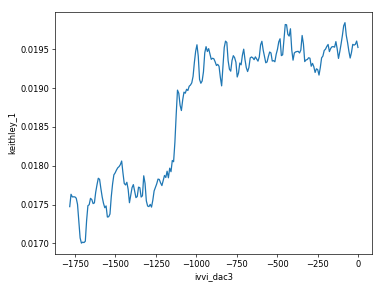

Starting experimental run with id: 7377
Measurement completed
data id =  7377


In [131]:

ivvi.dac1(1000)

ivvi.dac2(-100) #BG
#ivvi.dac3(-350) #RG

#ivvi.dac11(-0)  # TG1
#ivvi.dac12(0)  #TG1 fine
#
#ivvi.dac13(0)  # PG
#ivvi.dac14(1480)  #PG fine
#
#ivvi.dac15(-0)  # TG2
#ivvi.dac16(0)  #TG2 fine

start = 0
end = -2000
n_steps = 250

sweep_object = sweep(ivvi.dac3, np.linspace(start, end, n_steps))(
        measure_DC
    )
    
live_plot_axes = {"ivvi_dac3": 0, "conductance": 5}
dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
    (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )

## TG1 fine sweep 

In [150]:
ivvi.dac12(0)

<IPython.core.display.Javascript object>


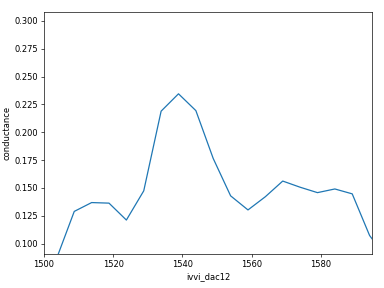

Starting experimental run with id: 7391
Measurement completed
data id =  7391


In [149]:
ivvi.dac1(-6)

#ivvi.dac2(-100)  #BG
#ivvi.dac3(-1500) #RG
#ivvi.dac11(-720)  # TG1
#ivvi.dac12(0)  #TG1 fine
#ivvi.dac13(500)  # PG
#ivvi.dac14(0)  #PG fine
#ivvi.dac9(0)  # TG2


start = 0
end = 2000
n_steps = 400

sweep_object = sweep(ivvi.dac12, np.linspace(start, end, n_steps))(
        measure_DC
    )
    
live_plot_axes = {"ivvi_dac12": 0, "conductance": 5}
dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
    (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )

## TG 2 sweep

<IPython.core.display.Javascript object>


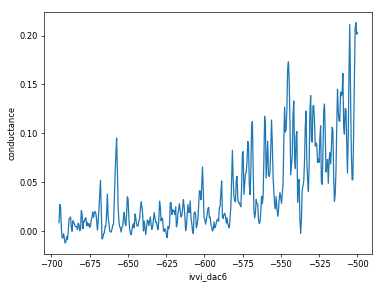

Starting experimental run with id: 7387
Measurement completed
data id =  7387


In [145]:
ivvi.dac1(-6)

ivvi.dac2(-100)  #BG
#ivvi.dac3(-1500) #RG
ivvi.dac11(-1800)  # TG1
#ivvi.dac12(0)  #TG1 fine
#ivvi.dac13(500)  # PG
#ivvi.dac14(0)  #PG fine

#
start = -500
end = -700
n_steps = 400

sweep_object = sweep(ivvi.dac6, np.linspace(start, end, n_steps))(
        measure_DC
    )
    
live_plot_axes = {"ivvi_dac6": 0, "conductance": 5}
dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
    (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )

## 1D Automated version of PG sweep + B fields

This function does the following:
-PG sweep in a given range
-load the file, find the minimum and define a grid with points separated by d_PG
-at each point of the grid, ramp Bperp (measuring the conductance and memorising also the value of dac14)
-change the dac14 to another PG in the grid and measure scanning Bperp in the opposite direction
-final PG sweep




In [22]:
Bz =ami_z.field()
By =ami_y.field()
Bx =ami_x.field()
Br = np.sqrt(By**2+Bx**2)
print(Bz)
print(By)
print(Bx)
print(Br)

-0.0
0.0
-0.0
0.0


In [31]:
ami_z.field(0)
ami_y.field(0)
ami_x.field(0)

In [ ]:

for n in np.linspace(0, 10, 20):

    #sweep PG
    ivvi.dac1(-6)
    start_PG = 400
    end_PG = 1200
    n_PG = 200

    d_PG = 202/5.
    start_Br = 1.25   #Start point in Bfield scan
    end_Br =   1.34  #End point in Bfield scan

    sweep_object = sweep(ivvi.dac14, np.linspace(start_PG, end_PG, n_PG))(
            measure_DC
        )
    live_plot_axes = {"dac 14": 0, "conductance": 5}

    d_dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ())
        ], 
        sweep_object, 
        [
        (end_DC, ())
        ], out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes]    
        )


    #finding the latest file
    list_of_files = glob.glob('data/*.txt') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    #extract and set at the minima
    filename = latest_file
    PG, G = a.extract(filename, 0, 5)[0], a.extract(filename, 0, 5)[1]
    minimum = np.argmin(G) # index of the minima
    conductance_minimum, PG_minimum = G[minimum], PG[minimum]
    print('Minimum PG found at:', PG_minimum)

    PG_r =  end_PG - PG_minimum
    PG_l =  PG_minimum - start_PG


    n_PGr = np.floor(abs(PG_r)/d_PG)
    n_PGl = np.floor(abs(PG_l)/d_PG)
    PG_start = PG_minimum - n_PGl*d_PG
    PG_end = PG_minimum + n_PGr*d_PG
    PGs = np.linspace(PG_start, PG_end, n_PGl + n_PGr +1)
    print('I am going to scan the field at PG =', PGs)


    start_y = start_Br*np.sin(phi_offset_rad)
    end_y = end_Br*np.sin(phi_offset_rad)
    start_x = start_Br*np.cos(phi_offset_rad)
    end_x = end_Br*np.cos(phi_offset_rad)
    start_z = ami_z.field()
    end_z = ami_z.field()
    print('x_start:', start_x)
    print('y_start:', start_y)
    print('x_end:', end_x)
    print('y_end:', end_y)
    ramp_factor = 1.0                #to prevent heating is less than 1
    ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
    ami_y.ramp_rate(ramp_y)
    ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
    ami_x.ramp_rate(ramp_x)


    for PG in PGs:     
        #set PG value for up sweep
        print('Setting PG:', PG)
        ivvi.dac14(PG)       
        expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
        print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
        print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 
        sweep_object = nest(
            time_trace(
                SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
                interval_time=0.6, # measure every n second
                total_time=None  # We do not have an end time; run until the SweepWhile is done
            ), 
            measure_DC  # use this measurement function
        )

        live_plot_axes = {"field y": 2, "conductance": 8}
        dataid = DoExperiment(
            "device1", 
            [
                (init_DC, ()), 
                (set_params, ()), 
                (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
            ], 
            sweep_object, 
            [
                (end_DC, ())
            ], 
            out_file = "device1_{counter}.txt",
            live_plot_axes=[live_plot_axes] 
        )    
        old_start_x = start_x
        old_start_y = start_y   
        start_x = end_x
        end_x = old_start_x   
        start_y = end_y
        end_y = old_start_y   



    #sweep PG again
    sweep_object = sweep(ivvi.dac14, np.linspace(start_PG, end_PG, n_PG))(
            measure_DC
        )

    live_plot_axes = {"ivvi_dac14": 0, "conductance": 5}
    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ())
        ], 
        sweep_object, 
        [
        (end_DC, ())
        ], out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes]    
        )




## Automated version in the double dot regime

This scipt iterates this measurement:
-2d gate map in PG fine, RG space
-find the minima in conductance
-define a grid in the gate space 
-sweep Bperp at each point

In [68]:
By =ami_y.field()
Bx =ami_x.field()
Br = np.sqrt(By**2+Bx**2)
print(By)
print(Bx)
print(Br)

1.21349
-0.20089
1.2300060049446913


In [ ]:
for n in np.linspace(0, 10, 20):
    

    ivvi.dac1(-6)
    start_PG = 800
    end_PG = 1500
    start_RG = -346
    end_RG = -343
    n_RG = 30
    n_PG = 80


    d_PG = 202/2.      #periodicity of the grid 202 in PG
    d_RG = 1.97/2      #periodicity of the grid in 1.97 RG
    
    start_Br = 1.23 #Start point in Bfield scan
    end_Br =   1.31   #End point in Bfield scan

    live_plot_axes = {"ivvi_dac14": 1, "conductance": 6}

    sweep_object = nest(
            sweep(ivvi.dac3, np.linspace(start_RG, end_RG, n_RG)), 
            sweep(ivvi.dac14, np.linspace(start_PG, end_PG, n_PG)),
        measure_DC
    ) 

    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ())
        ], 
        sweep_object, 
        [
            (end_DC, ())
        ], out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes] 

    )


    #finding the latest file
    list_of_files = glob.glob('data/*.txt') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    #extract and set at the minima
    filename = latest_file
    RG, G = a.extract(filename, 0, 6)[0], a.extract(filename, 0, 6)[1]
    PG, G = a.extract(filename, 1, 6)[0], a.extract(filename, 1, 6)[1]    
    minimum = np.argmin(G) # index of the minima
    conductance_minimum, PG_minimum, RG_minimum = G[minimum], PG[minimum], RG[minimum]
    
    print('Minimum PG found at:', PG_minimum)
    print('Minimum RG found at:', RG_minimum)
    print("conductance:",conductance_minimum )
    
    PG_r =  end_PG - PG_minimum
    PG_l =  PG_minimum - start_PG
    RG_t =  end_RG - RG_minimum
    RG_b =  RG_minimum - start_RG
    
    n_PGr = np.floor(abs(PG_r)/d_PG)
    n_PGl = np.floor(abs(PG_l)/d_PG)
    PG_start = PG_minimum - n_PGl*d_PG
    PG_end = PG_minimum + n_PGr*d_PG
    PGs = np.linspace(PG_start, PG_end, n_PGl + n_PGr +1)
    
    
    n_RGt =  np.floor(abs(RG_t)/d_RG)
    n_RGb = np.floor(abs(RG_b)/d_RG)
    RG_start = RG_minimum - n_RGb*d_RG
    RG_end = RG_minimum + n_RGt*d_RG
    RGs = np.linspace(RG_start, RG_end, n_RGt + n_RGb +1) 
    
    
    print('I am going to scan the field at PG =', PGs)
    print('I am going to scan the field at RG =', RGs)

    start_y = start_Br*np.sin(phi_offset_rad)
    end_y = end_Br*np.sin(phi_offset_rad)
    start_x = start_Br*np.cos(phi_offset_rad)
    end_x = end_Br*np.cos(phi_offset_rad)
    start_z = ami_z.field()
    end_z = ami_z.field()

    print('x_start:', start_x)
    print('y_start:', start_y)
    print('x_end:', end_x)
    print('y_end:', end_y)

    ramp_factor = 1.0                #to prevent heating is less than 1
    ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
    ami_y.ramp_rate(ramp_y)
    ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
    ami_x.ramp_rate(ramp_x)

    for RG in RGs:
        ivvi.dac3(RG)    
        for PG in PGs:     
            ivvi.dac14(PG)
            print('Setting RG and PG at:', RG, PG)   
            expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
            print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
            print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 

            sweep_object = nest(
                time_trace(
                    SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
                    interval_time=0.6, # measure every n second
                    total_time=None  # We do not have an end time; run until the SweepWhile is done
                ), 
                measure_DC  # use this measurement function
            )

            live_plot_axes = {"field y": 2, "conductance": 8}
            dataid = DoExperiment(
                "device1", 
                [
                    (init_DC, ()), 
                    (set_params, ()), 
                    (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
                ], 
                sweep_object, 
                [
                    (end_DC, ())
                ], 
                out_file = "device1_{counter}.txt",
                live_plot_axes=[live_plot_axes] 
            )
            old_start_x = start_x
            old_start_y = start_y   
            start_x = end_x
            end_x = old_start_x   
            start_y = end_y
            end_y = old_start_y    



## Automated version in the double dot regime with gate zoom-in feature

In [ ]:
This script iterates this measurement:
-large gate map of RG vs PG fine
-find the minimum point of the conductance
-define a second smaller window in the space (RG, PG fine) around the minimum
-perform an other finer PG vs RG 2d scan
-find the minimum
-define a grid to fully cover the second gate window with a given periodicity d_PG, and d_RG
-sweep Bperp at each point of the grid from start_Br to end_Br
-remeasure the zoom in gatemap


In [27]:
By =ami_y.field()
Bx =ami_x.field()
Br = np.sqrt(By**2+Bx**2)
print(By)
print(Bx)
print(Br)

1.26281
-0.20906
1.2799981170689276


In [ ]:
for n in np.linspace(0, 10, 20):
    
    #first large gate map
    ivvi.dac1(-6)
    start_PG = 600
    end_PG = 1400
    start_RG = -350
    end_RG = -340
    n_RG = 20
    n_PG = 30
    
    #second smaller gate map
    width_PG = 500
    width_RG = 3.0
    


    d_PG = 202/5.      #periodicity of the grid in PG
    d_RG = 1.97/2.      #periodicity of the grid in RG
    
    start_Br = 1.28 #Start point in Bfield scan
    end_Br =   1.33   #End point in Bfield scan

    live_plot_axes = {"ivvi_dac14": 1, "conductance": 6}
    sweep_object = nest(
            sweep(ivvi.dac3, np.linspace(start_RG, end_RG, n_RG)), 
            sweep(ivvi.dac14, np.linspace(start_PG, end_PG, n_PG)),
        measure_DC
    ) 

    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ())
        ], 
        sweep_object, 
        [
            (end_DC, ())
        ], out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes] 

    )


     #finding the latest file
    list_of_files = glob.glob('data/*.txt') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    #extract and set at the minima
    filename = latest_file
    RG, G = a.extract(filename, 0, 6)[0], a.extract(filename, 0, 6)[1]
    PG, G = a.extract(filename, 1, 6)[0], a.extract(filename, 1, 6)[1]    
    minimum = np.argmin(G) # index of the minima
    conductance_minimum, PG_minimum, RG_minimum = G[minimum], PG[minimum], RG[minimum]
    print('Defining a second window around PG:', PG_minimum, ',RG: ', RG_minimum) 
    
    
    
    
    
    start_PG = PG_minimum - 0.5*width_PG
    end_PG = PG_minimum + 0.5*width_PG
    start_RG = RG_minimum - 0.5*width_RG
    end_RG = RG_minimum + 0.5*width_RG
    n_RG = 30
    n_PG = 60
    
    #defining the second gate map from the minimum
    live_plot_axes = {"ivvi_dac14": 1, "conductance": 6}
    sweep_object = nest(
            sweep(ivvi.dac3, np.linspace(start_RG, end_RG, n_RG)), 
            sweep(ivvi.dac14, np.linspace(start_PG, end_PG, n_PG)),
        measure_DC
    ) 

    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ())
        ], 
        sweep_object, 
        [
            (end_DC, ())
        ], out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes] 

    )      
    
    
    #finding the latest file
    list_of_files = glob.glob('data/*.txt') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    #extract and set at the minima
    filename = latest_file
    RG, G = a.extract(filename, 0, 6)[0], a.extract(filename, 0, 6)[1]
    PG, G = a.extract(filename, 1, 6)[0], a.extract(filename, 1, 6)[1]    
    minimum = np.argmin(G) # index of the minima
    conductance_minimum, PG_minimum, RG_minimum = G[minimum], PG[minimum], RG[minimum]
    
    print('Minimum PG found at:', PG_minimum)
    print('Minimum RG found at:', RG_minimum)
    print("conductance:",conductance_minimum )
    
    PG_r =  end_PG - PG_minimum
    PG_l =  PG_minimum - start_PG
    RG_t =  end_RG - RG_minimum
    RG_b =  RG_minimum - start_RG
    
    n_PGr = np.floor(abs(PG_r)/d_PG)
    n_PGl = np.floor(abs(PG_l)/d_PG)
    PG_start = PG_minimum - n_PGl*d_PG
    PG_end = PG_minimum + n_PGr*d_PG
    PGs = np.linspace(PG_start, PG_end, n_PGl + n_PGr +1)
    
    
    n_RGt =  np.floor(abs(RG_t)/d_RG)
    n_RGb = np.floor(abs(RG_b)/d_RG)
    RG_start = RG_minimum - n_RGb*d_RG
    RG_end = RG_minimum + n_RGt*d_RG
    RGs = np.linspace(RG_start, RG_end, n_RGt + n_RGb +1) 
    
    
    print('I am going to scan the field at PG =', PGs)
    print('I am going to scan the field at RG =', RGs)

    start_y = start_Br*np.sin(phi_offset_rad)
    end_y = end_Br*np.sin(phi_offset_rad)
    start_x = start_Br*np.cos(phi_offset_rad)
    end_x = end_Br*np.cos(phi_offset_rad)
    start_z = ami_z.field()
    end_z = ami_z.field()

    print('x_start:', start_x)
    print('y_start:', start_y)
    print('x_end:', end_x)
    print('y_end:', end_y)

    ramp_factor = 1.0                #to prevent heating is less than 1
    ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
    ami_y.ramp_rate(ramp_y)
    ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
    ami_x.ramp_rate(ramp_x)

    for RG in RGs:
        ivvi.dac3(RG)    
        for PG in PGs:     
            ivvi.dac14(PG)
            print('Setting RG and PG at:', RG, PG)   
            expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
            print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
            print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 

            sweep_object = nest(
                time_trace(
                    SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
                    interval_time=0.6, # measure every n second
                    total_time=None  # We do not have an end time; run until the SweepWhile is done
                ), 
                measure_DC  # use this measurement function
            )

            live_plot_axes = {"field y": 2, "conductance": 8}
            dataid = DoExperiment(
                "device1", 
                [
                    (init_DC, ()), 
                    (set_params, ()), 
                    (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
                ], 
                sweep_object, 
                [
                    (end_DC, ())
                ], 
                out_file = "device1_{counter}.txt",
                live_plot_axes=[live_plot_axes] 
            )
            old_start_x = start_x
            old_start_y = start_y   
            start_x = end_x
            end_x = old_start_x   
            start_y = end_y
            end_y = old_start_y
            
            #defining the second gate map from the minimum
    live_plot_axes = {"ivvi_dac14": 1, "conductance": 6}
    sweep_object = nest(
            sweep(ivvi.dac3, np.linspace(start_RG, end_RG, n_RG)), 
            sweep(ivvi.dac14, np.linspace(start_PG, end_PG, n_PG)),
        measure_DC
    ) 

    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ())
        ], 
        sweep_object, 
        [
            (end_DC, ())
        ], out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes] 

    )


## Single magnetoconductance trace (one sweep direction)


x_start: 0.02286563471382714
y_start: -0.13812010262497573
x_end: 0.016332596224162242
y_end: -0.09865721616069695
New rates are:
rate y: 0.0001452
rate x: 2.4832338970865088e-05
Total measurement time: 4.53 minutes.
Total measurement time: 0.08 hours.


<IPython.core.display.Javascript object>


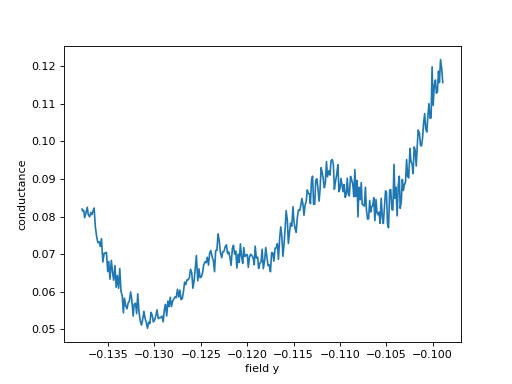

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 1830
Measurement completed
data id =  1830


In [22]:
ivvi.dac1(-6)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = -0.140
end_Br =  -0.100
   
start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)
start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)
start_z = ami_z.field()
end_z = ami_z.field()
print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)

ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 

sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]
)

In [79]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = -0.14
end_Br = -0.1

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


x_start: 0.02286563471382714
y_start: -0.13812010262497573
x_end: 0.016332596224162242
y_end: -0.09865721616069695
New rates are:
rate y: 0.0001452
rate x: 2.4832338970865088e-05
Total measurement time: 4.53 minutes.
Total measurement time: 0.08 hours.


ValueError: Mismatch between function call signature and the provided arguments.

x_start: -0.13066076979329794
y_start: 0.7892577292855756
x_end: -0.14699336601746016
y_end: 0.8879149454462725
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


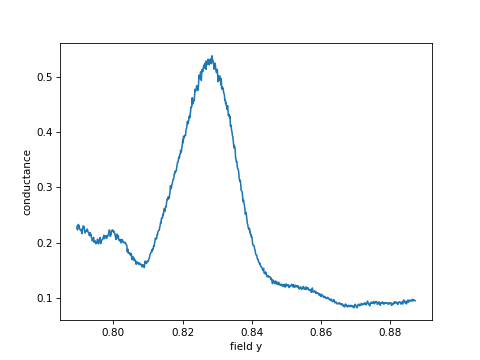

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 477
Measurement completed
data id =  477


In [632]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.8
end_Br = 0.9

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


<IPython.core.display.Javascript object>


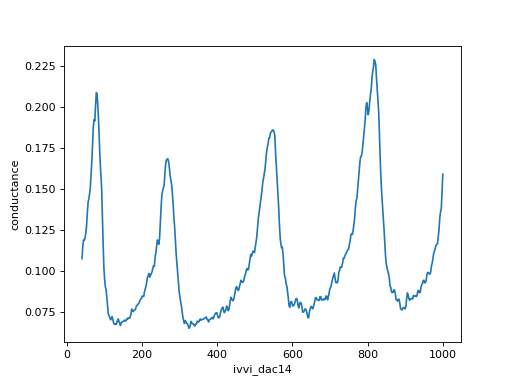

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


Starting experimental run with id: 1407
Measurement completed
data id =  1407


In [35]:
ivvi.dac1(-6)

#ivvi.dac3(-130) #RG
#TG1 and T1G2 at
#ivvi.dac11(-230.)  #TG1 coarse
#ivvi.dac15(-300)   #TG2 coarse

#dac 13,14 == PG coarse, PG fine
#ivvi.dac13(0)  #PG coarse

V_start = 1000
V_end = 0
n_steps = 500


sweep_object = sweep(ivvi.dac14, np.linspace(V_start, V_end, n_steps))(
    measure_DC
)

live_plot_axes = {"ivvi_dac14": 0, "conductance": 5}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )

x_start: -0.14699336601746016
y_start: 0.8879149454462725
x_end: -0.13066076979329794
y_end: 0.7892577292855756
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


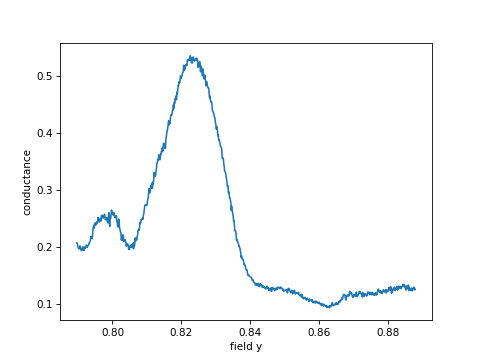

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 479
Measurement completed
data id =  479


In [634]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.9
end_Br = 0.8

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


x_start: -0.13066076979329794
y_start: 0.7892577292855756
x_end: -0.14699336601746016
y_end: 0.8879149454462725
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


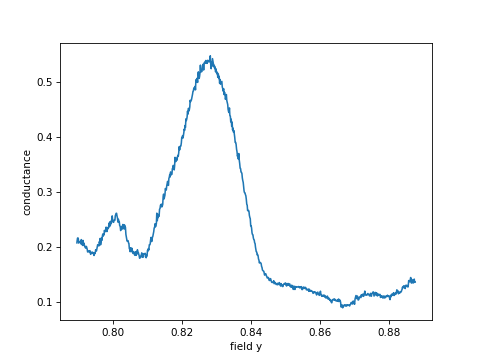

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 480
Measurement completed
data id =  480


In [635]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.8
end_Br = 0.9

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


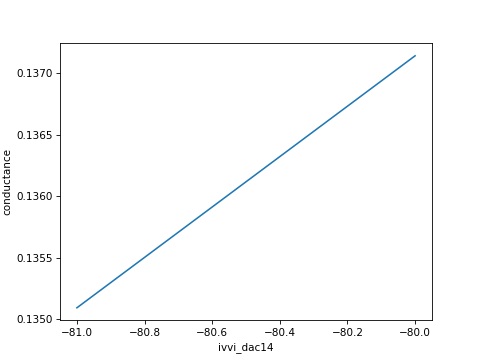

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


Starting experimental run with id: 481
Measurement completed
data id =  481


In [636]:
ivvi.dac1(0)

#ivvi.dac3(-130) #RG
#TG1 and T1G2 at
#ivvi.dac11(-230.)  #TG1 coarse
#ivvi.dac15(-300)   #TG2 coarse

#dac 13,14 == PG coarse, PG fine
#ivvi.dac13(0)  #PG coarse

V_start = -80
V_end = -100
n_steps = 21


sweep_object = sweep(ivvi.dac14, np.linspace(V_start, V_end, n_steps))(
    measure_DC
)

live_plot_axes = {"ivvi_dac14": 0, "conductance": 5}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )

x_start: -0.14699336601746016
y_start: 0.8879149454462725
x_end: -0.13066076979329794
y_end: 0.7892577292855756
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


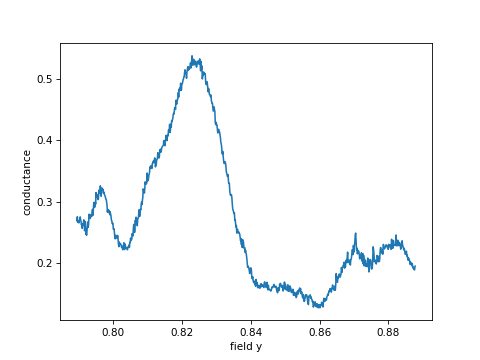

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 482
Measurement completed
data id =  482


In [637]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.9
end_Br = 0.8

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


x_start: -0.13066076979329794
y_start: 0.7892577292855756
x_end: -0.14699336601746016
y_end: 0.8879149454462725
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


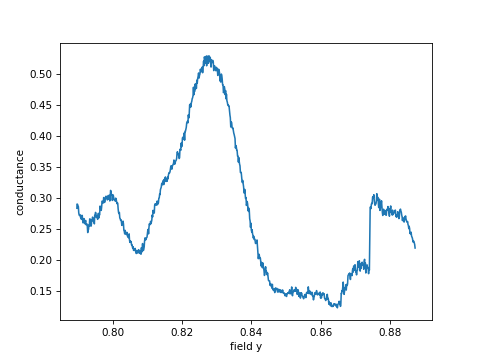

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 483
Measurement completed
data id =  483


In [638]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.8
end_Br = 0.9

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


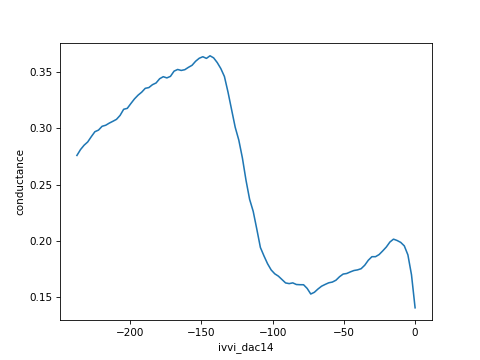

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


Starting experimental run with id: 520
Measurement completed
data id =  520


In [678]:
ivvi.dac1(0)

#ivvi.dac3(-130) #RG
#TG1 and T1G2 at
#ivvi.dac11(-230.)  #TG1 coarse
#ivvi.dac15(-300)   #TG2 coarse

#dac 13,14 == PG coarse, PG fine
#ivvi.dac13(0)  #PG coarse

V_start = 0
V_end = -250
n_steps = 100


sweep_object = sweep(ivvi.dac14, np.linspace(V_start, V_end, n_steps))(
    measure_DC
)

live_plot_axes = {"ivvi_dac14": 0, "conductance": 5}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )

x_start: -0.14699336601746016
y_start: 0.8879149454462725
x_end: -0.13066076979329794
y_end: 0.7892577292855756
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


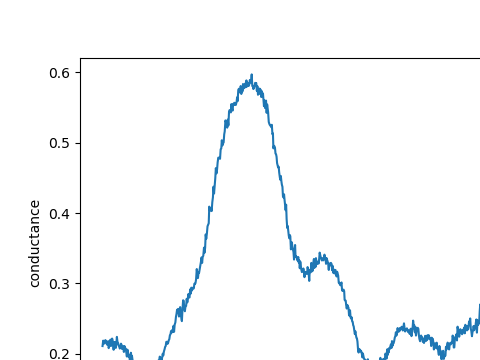

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 485


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\axes\_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.11985835525283563, top=0.11985835525283563
  'bottom=%s, top=%s') % (bottom, top))


Measurement completed
data id =  485


In [640]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.9
end_Br = 0.8

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


x_start: -0.13066076979329794
y_start: 0.7892577292855756
x_end: -0.14699336601746016
y_end: 0.8879149454462725
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


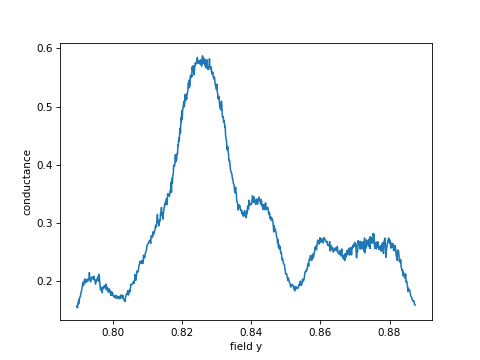

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 486
Measurement completed
data id =  486


In [641]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.8
end_Br = 0.9

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


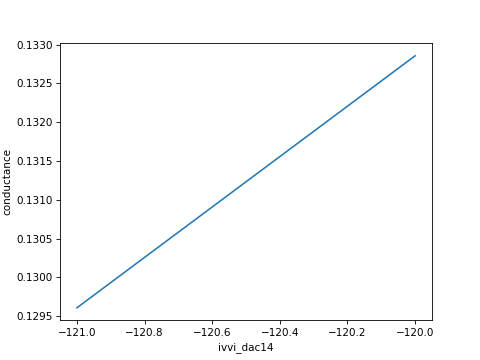

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


Starting experimental run with id: 487
Measurement completed
data id =  487


In [642]:
ivvi.dac1(0)

#ivvi.dac3(-130) #RG
#TG1 and T1G2 at
#ivvi.dac11(-230.)  #TG1 coarse
#ivvi.dac15(-300)   #TG2 coarse

#dac 13,14 == PG coarse, PG fine
#ivvi.dac13(0)  #PG coarse

V_start = -120
V_end = -140
n_steps = 21


sweep_object = sweep(ivvi.dac14, np.linspace(V_start, V_end, n_steps))(
    measure_DC
)

live_plot_axes = {"ivvi_dac14": 0, "conductance": 5}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )

x_start: -0.14699336601746016
y_start: 0.8879149454462725
x_end: -0.13066076979329794
y_end: 0.7892577292855756
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


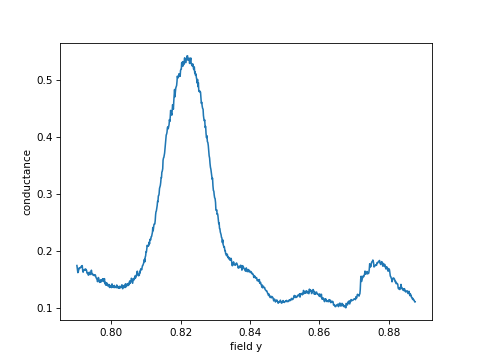

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 488
Measurement completed
data id =  488


In [643]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.9
end_Br = 0.8

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


x_start: -0.13066076979329794
y_start: 0.7892577292855756
x_end: -0.14699336601746016
y_end: 0.8879149454462725
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


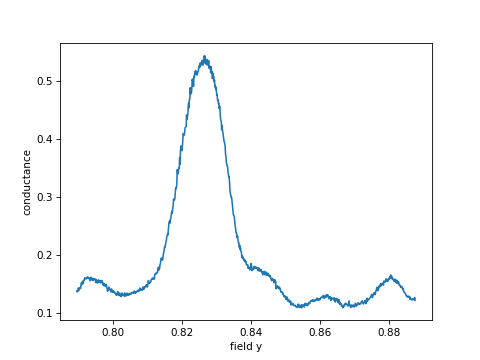

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 489
Measurement completed
data id =  489


In [644]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.8
end_Br = 0.9

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


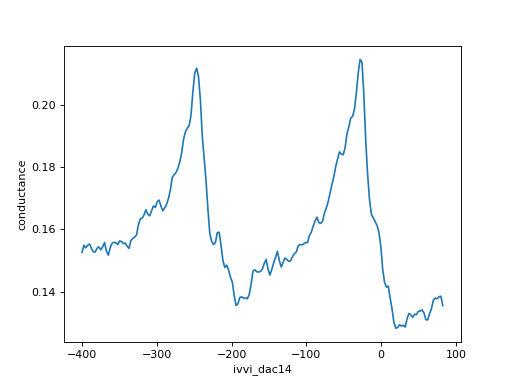

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


Starting experimental run with id: 664
Measurement completed
data id =  664


In [833]:
ivvi.dac1(0)

#ivvi.dac3(-130) #RG
#TG1 and T1G2 at
#ivvi.dac11(-230.)  #TG1 coarse
#ivvi.dac15(-300)   #TG2 coarse

#dac 13,14 == PG coarse, PG fine
#ivvi.dac13(0)  #PG coarse

V_start = -400
V_end = 100
n_steps = 200


sweep_object = sweep(ivvi.dac14, np.linspace(V_start, V_end, n_steps))(
    measure_DC
)

live_plot_axes = {"ivvi_dac14": 0, "conductance": 5}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )

x_start: -0.14699336601746016
y_start: 0.8879149454462725
x_end: -0.13066076979329794
y_end: 0.7892577292855756
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


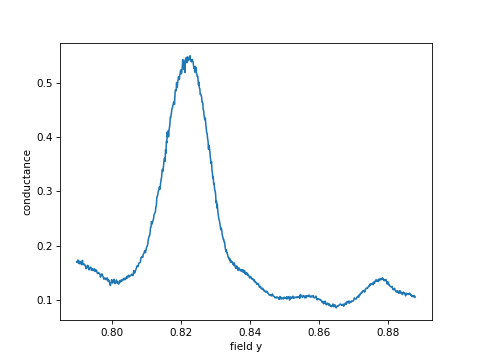

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 491
Measurement completed
data id =  491


In [646]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.9
end_Br = 0.8

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


x_start: -0.13066076979329794
y_start: 0.7892577292855756
x_end: -0.14699336601746016
y_end: 0.8879149454462725
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


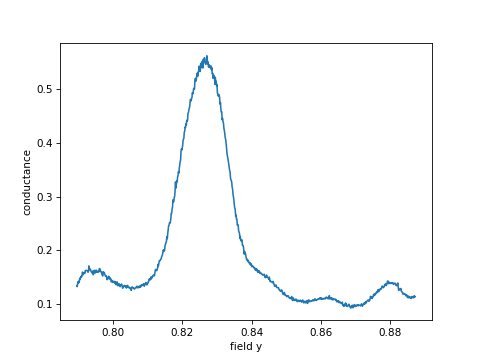

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 492
Measurement completed
data id =  492


In [647]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.8
end_Br = 0.9

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


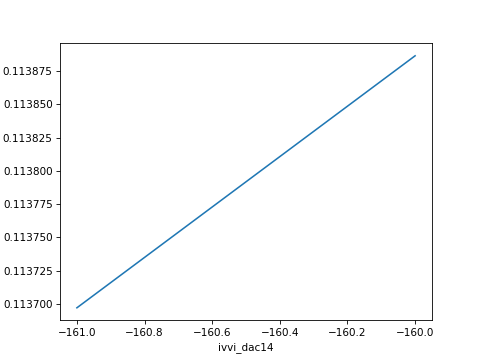

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


Starting experimental run with id: 493
Measurement completed
data id =  493


In [648]:
ivvi.dac1(0)

#ivvi.dac3(-130) #RG
#TG1 and T1G2 at
#ivvi.dac11(-230.)  #TG1 coarse
#ivvi.dac15(-300)   #TG2 coarse

#dac 13,14 == PG coarse, PG fine
#ivvi.dac13(0)  #PG coarse

V_start = -160
V_end = -180
n_steps = 21


sweep_object = sweep(ivvi.dac14, np.linspace(V_start, V_end, n_steps))(
    measure_DC
)

live_plot_axes = {"ivvi_dac14": 0, "conductance": 5}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )

x_start: -0.14699336601746016
y_start: 0.8879149454462725
x_end: -0.13066076979329794
y_end: 0.7892577292855756
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


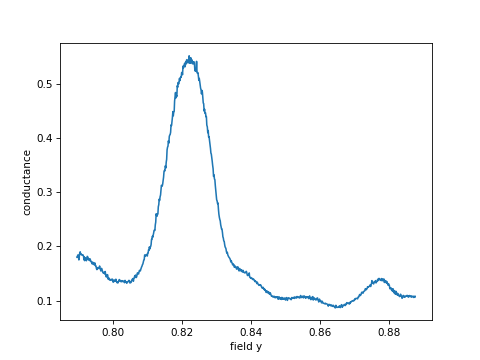

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 494
Measurement completed
data id =  494


In [649]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.9
end_Br = 0.8

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


x_start: -0.13066076979329794
y_start: 0.7892577292855756
x_end: -0.14699336601746016
y_end: 0.8879149454462725
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


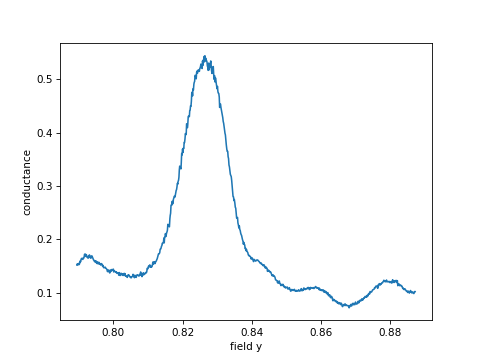

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 495
Measurement completed
data id =  495


In [650]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.8
end_Br = 0.9

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


<IPython.core.display.Javascript object>


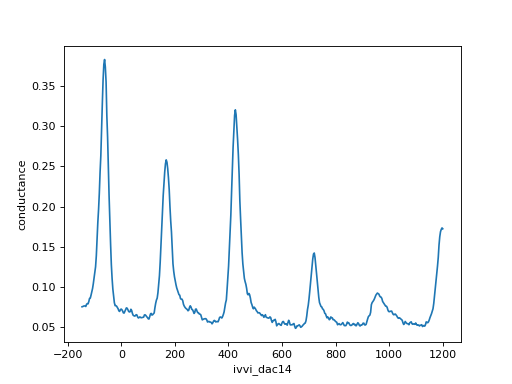

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


Starting experimental run with id: 1743
Measurement completed
data id =  1743


In [47]:
ivvi.dac1(-6)


#TG1 and T1G2 at
#ivvi.dac11(-230.)  #TG1 coarse
#ivvi.dac15(-300)   #TG2 coarse

#dac 13,14 == PG coarse, PG fine
#ivvi.dac13(0)  #PG coarse

V_start = 1200
V_end = -200
n_steps = 500


sweep_object = sweep(ivvi.dac14, np.linspace(V_start, V_end, n_steps))(
    measure_DC
)

live_plot_axes = {"ivvi_dac14": 0, "conductance": 5}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ())
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
    )

x_start: -0.14699336601746016
y_start: 0.8879149454462725
x_end: -0.13066076979329794
y_end: 0.7892577292855756
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


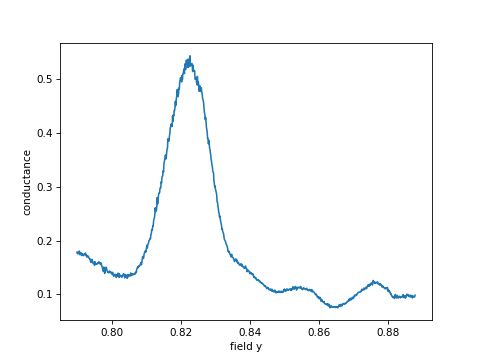

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 497
Measurement completed
data id =  497


In [652]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.9
end_Br = 0.8

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


x_start: -0.13066076979329794
y_start: 0.7892577292855756
x_end: -0.14699336601746016
y_end: 0.8879149454462725
New rates are:
rate y: 0.0001452
rate x: 2.483233897086507e-05
Total measurement time: 11.32 minutes.
Total measurement time: 0.19 hours.


C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


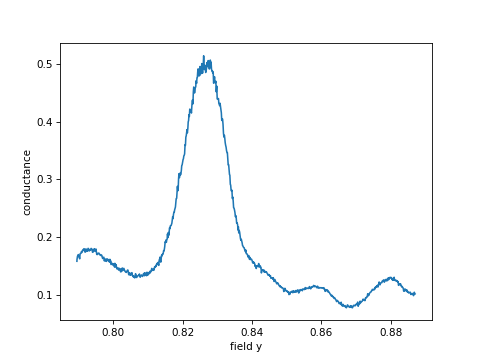

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


setting x start
setting y start
setting z start
setting x end
setting y end
setting z end
Starting experimental run with id: 498
Measurement completed
data id =  498


In [653]:
ivvi.dac1(0)
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001

start_Br = 0.8
end_Br = 0.9

start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)

start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)

start_z = 0.0
end_z = 0.0

print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)



ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 





sweep_object = nest(
    time_trace(
        SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]    
)


In [36]:
ami_y.field()

-0.10852

## Multiple magnetoconductance trace (one sweep direction)

In [41]:
ami_x.field_ramp_limit()
ivvi.dac3()

-347.9972533760588

In [219]:
ami_x.ramp_rate(6e-4)

In [96]:
By =ami_y.field()
Bx =ami_x.field()
Br = np.sqrt(By**2+Bx**2)
print(By)
print(Bx)
print(Br)

1.17402
-0.19436
1.1899994831931653


In [ ]:
#PGs = np.linspace(-1000, -500, 20)
ivvi.dac3(-349)
PGs = [430, 430]
start_Br = 1.19
end_Br =  1.29
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001
start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)
start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)
start_z = 2.
end_z = 2.
print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)

ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
    

for PG in PGs:      
    ivvi.dac14(PG)
    print('Setting PG:', PG)
    expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
    print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
    print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.')
    sweep_object = nest(
        time_trace(
            SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
            interval_time=0.6, # measure every n second
            total_time=None  # We do not have an end time; run until the SweepWhile is done
        ), 
        measure_DC  # use this measurement function
    )

    live_plot_axes = {"field y": 2, "conductance": 8}
    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ()), 
            (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
        ], 
        sweep_object, 
        [
            (end_DC, ())
        ], 
        out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes]    
    )
    
    old_start_x = start_x
    old_start_y = start_y   
    start_x = end_x
    end_x = old_start_x   
    start_y = end_y
    end_y = old_start_y 
    




## Multiple magnetoconductance trace (both sweep directions)

In [115]:
Br = 0.585
start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)
start_x = start_Br*np.cos(phi_offset_rad)

print(start_x)
ami_y.field()

-0.02286563471382714


0.13811

In [ ]:
PG_start = -750
PG_end = -200
PG_steps = 15

start_Br = 0.140
end_Br =   0.230




PG_ups = np.linspace(PG_start, PG_end, PG_steps)
step = (PG_ups[1]-PG_ups[0])/2.
PG_downs = PG_ups + step

phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001
ivvi.dac1(-6)

for (PG_up, PG_down) in zip(PG_ups, PG_downs): 
    
    #set PG value for up sweep
    ivvi.dac14(PG_up)
    print('Setting PG for up direction:', PG_up)
    
    start_y = start_Br*np.sin(phi_offset_rad)
    end_y = end_Br*np.sin(phi_offset_rad)
    start_x = start_Br*np.cos(phi_offset_rad)
    end_x = end_Br*np.cos(phi_offset_rad)
    start_z = 2
    end_z = 2
    print('x_start:', start_x)
    print('y_start:', start_y)
    print('x_end:', end_x)
    print('y_end:', end_y)

    ramp_factor = 1.0                #to prevent heating is less than 1
    ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
    ami_y.ramp_rate(ramp_y)
    ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
    ami_x.ramp_rate(ramp_x)
    print('New rates are:')
    print('rate y:',ramp_y)
    print('rate x:',ramp_x)
    expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
    print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
    print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 

    sweep_object = nest(
        time_trace(
            SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
            interval_time=0.6, # measure every n second
            total_time=None  # We do not have an end time; run until the SweepWhile is done
        ), 
        measure_DC  # use this measurement function
    )

    live_plot_axes = {"field y": 2, "conductance": 8}

    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ()), 
            (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
        ], 
        sweep_object, 
        [
            (end_DC, ())
        ], 
        out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes] 
    )
    
    #set PG value for down sweep
    ivvi.dac14(PG_down)
    print('Setting PG for down direction:', PG_down)

    print('x_start:', end_x)
    print('y_start:', end_y)
    print('x_end:', start_x)
    print('y_end:', start_y)

    ramp_factor = 1.0                #to prevent heating is less than 1
    ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
    ami_y.ramp_rate(ramp_y)
    ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
    ami_x.ramp_rate(ramp_x)
    print('New rates are:')
    print('rate y:',ramp_y)
    print('rate x:',ramp_x)
    expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
    print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
    print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 

    sweep_object = nest(
        time_trace(
            SweepWhile(not_at_setpoint((start_x, start_y, start_z), tolerance)), # Take a time trace while we are not at the end point
            interval_time=0.6, # measure every n second
            total_time=None  # We do not have an end time; run until the SweepWhile is done
        ), 
        measure_DC  # use this measurement function
    )

    live_plot_axes = {"field y": 2, "conductance": 8}

    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ()), 
            (goto_setpoint, (end_x, end_y, end_z, start_x, start_y, start_z))
        ], 
        sweep_object, 
        [
            (end_DC, ())
        ], 
        out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes] 
    )
    


## Multiple magnetoconductance trace (single sweep direction) + PG trace in between

In [88]:
ami_z.field()

2.00001

In [ ]:
#This script goes from a starting point to each PG in PGs measuring the conductance, then register the AB 
#in both directions for the same PG


PGs = np.linspace(-900, -200 , 25)
last = PGs[0]-50
nsteps = 50

start_Br = 0.594
end_Br =  0.674

phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0
tolerance = 0.0001
ivvi.dac1(-6)

for PG in PGs:
    
    print('Setting the magnetic field and the rate:')
    start_y = start_Br*np.sin(phi_offset_rad)
    end_y = end_Br*np.sin(phi_offset_rad)
    start_x = start_Br*np.cos(phi_offset_rad)
    end_x = end_Br*np.cos(phi_offset_rad)
    start_z = 2
    end_z = 2    
    print('x_start:', start_x)
    print('y_start:', start_y)
    print('x_end:', end_x)
    print('y_end:', end_y)    
    ramp_factor = 1.0                #to prevent heating is less than 1
    ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
    ami_y.ramp_rate(ramp_y)
    ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
    ami_x.ramp_rate(ramp_x)
    ami_x.field(start_x)
    ami_y.field(start_y)
    
    
    print('Sweeping from', last, 'to', PG)
    sweep_object = sweep(ivvi.dac14, np.linspace(last, PG, n_steps))(
        measure_DC
    )
    live_plot_axes = {"ivvi_dac14": 0, "conductance": 5}
    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ())
        ], 
        sweep_object, 
        [
        (end_DC, ())
        ], out_file = "device1_{counter}.txt",
        live_plot_axes=[live_plot_axes]    
        )
    
    #AB up measurement
    print('PREPARING FOR THE MAGNETIC SWEEP UP AT PG:', PG)
    expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
    print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
    print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 

    sweep_object = nest(
        time_trace(
            SweepWhile(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
            interval_time=0.6, # measure every n second
            total_time=None  # We do not have an end time; run until the SweepWhile is done
        ), 
        measure_DC  # use this measurement function
    )


    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ()), 
            (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
        ], 
        sweep_object, 
        [
            (end_DC, ())
        ], 
        out_file = "device1_{counter}.txt"          
    )
    
    
    print('PREPARING FOR THE MAGNETIC SWEEP DOWN AT PG:', PG)
    print('x_start:', end_x)
    print('y_start:', end_y)
    print('x_end:', start_x)
    print('y_end:', start_y)

    ramp_factor = 1.0                #to prevent heating is less than 1
    ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
    ami_y.ramp_rate(ramp_y)
    ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
    ami_x.ramp_rate(ramp_x)
    #print('New rates are:')
    #print('rate y:',ramp_y)
    #print('rate x:',ramp_x)
    expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
    print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
    print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 

    sweep_object = nest(
        time_trace(
            SweepWhile(not_at_setpoint((start_x, start_y, start_z), tolerance)), # Take a time trace while we are not at the end point
            interval_time=0.6, # measure every n second
            total_time=None  # We do not have an end time; run until the SweepWhile is done
        ), 
        measure_DC  # use this measurement function
    )

   
    dataid = DoExperiment(
        "device1", 
        [
            (init_DC, ()), 
            (set_params, ()), 
            (goto_setpoint, (end_x, end_y, end_z, start_x, start_y, start_z))
        ], 
        sweep_object, 
        [
            (end_DC, ())
        ], 
        out_file = "device1_{counter}.txt"   
    )
        
        
    last = PG




Plotting by dataid


In [137]:
fig = plot_by_id(dataid)

InterfaceError: Error binding parameter 0 - probably unsupported type.

In [134]:
data = export_as_dict(dataid=144)

In [135]:
data.keys()

dict_keys(['ivvi_dac1 [mV]', 'keithley_1 [V]', 'lockin_1_X [V]', 'lockin_1_phase [deg]', 'lockin_1_processed [S]', 'conductance [G_0]'])

<IPython.core.display.Javascript object>


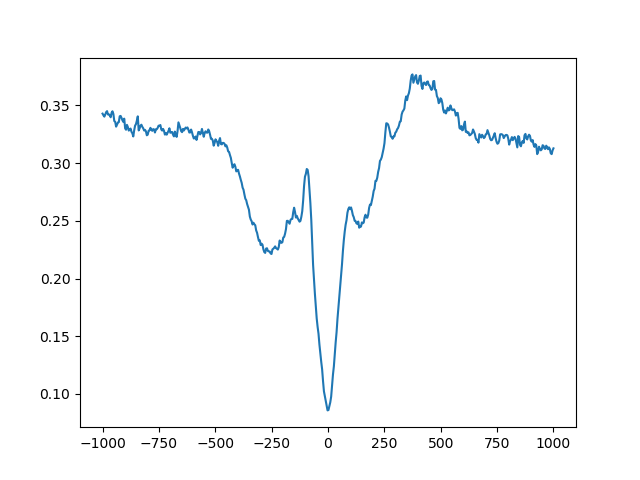

In [136]:
fig, ax = plt.subplots()

ax.plot(data['ivvi_dac1 [mV]'], data['conductance [G_0]'])

## dataid useful tricks


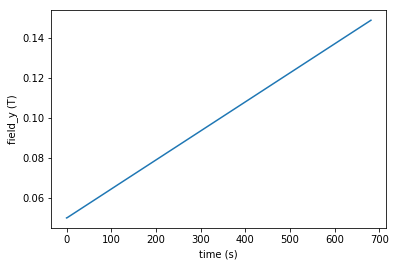

In [59]:
fig = plot_by_id(dataid)

In [60]:
data = export_as_dict(dataid)

In [61]:
data.keys()

dict_keys(['time [s]', 'field_y [T]', 'keithley_1 [V]', 'keithley_2 [V]', 'lockin_1_X [V]', 'lockin_1_phase [deg]', 'lockin_1_processed [S]'])

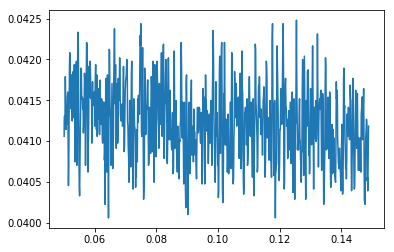

In [62]:
fig, ax = plt.subplots()

ax.plot(data['field_y [T]'], 12906*data['lockin_1_processed [S]'])



In [215]:
AMI._set_fields((0, 0, 0), block=False)